In [1]:
from keras.layers import Conv3D,Conv2D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.layers import Add, Activation, AveragePooling2D, MaxPooling2D, ReLU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
import plotly.express as px

plt.style.use('Solarize_Light2')

init_notebook_mode(connected=True)
%matplotlib inline

In [43]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.2
windowSize = 25
S = windowSize
K = 9
output_units = 9

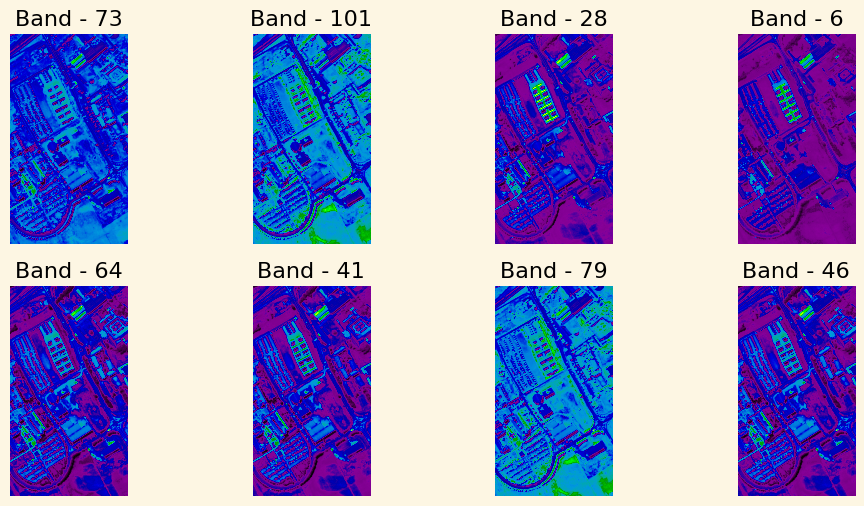

In [58]:
X, y = loadData(dataset)

fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    q = np.random.randint(X.shape[2])  #random
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('PU_Bands.png')

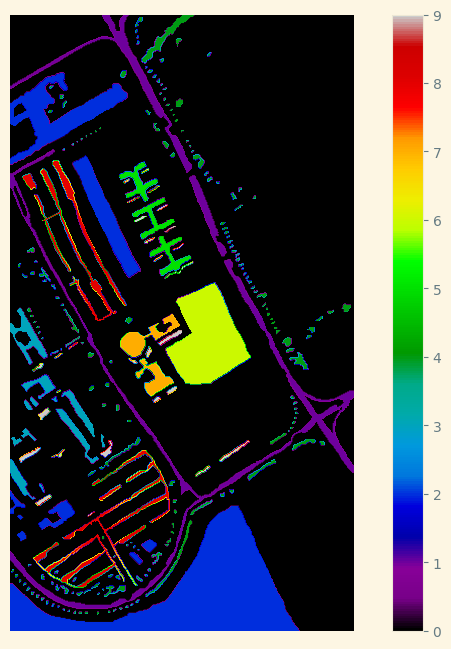

In [4]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
if (dataset == 'PU' or dataset == 'PC'):
    plt.savefig('PU_GT.png') 
elif (dataset == 'Bot'):
    plt.savefig('Bot_GT.png') 
elif (dataset == 'SA'):
    plt.savefig('SA_GT.png') 
else:
    plt.savefig('IP_GT.png') 

plt.show()

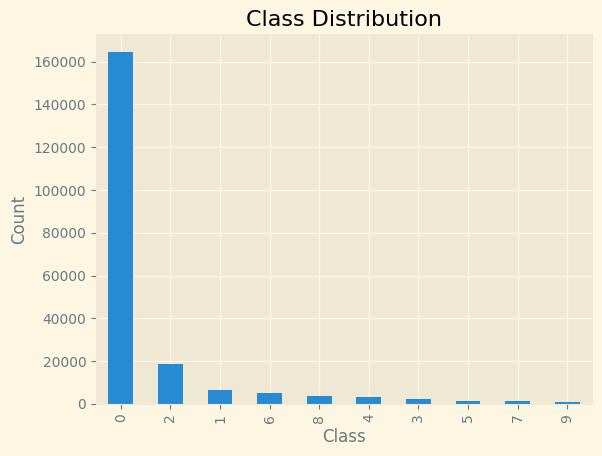

In [6]:
plot_class_distribution(y)

In [8]:
class_counts = pd.Series(y.flatten()).value_counts()
bar_fig = px.bar(x=class_counts.index[1:], y=class_counts[1:], labels=y, color=class_counts.index[1:])
bar_fig.update_layout(
        xaxis=dict(
            title='Class',
            tickmode='array',
            tickvals=class_counts.index[1:].tolist(),
            tickangle=45
        ),
        yaxis=dict(
            title='count',
        ),
        showlegend=False
)
bar_fig.show()


In [60]:
K = 9
X,pca = applyPCA(X,numComponents=K)
X.shape

(610, 340, 9)

X.shape (610, 340, 9)
y.shape (610, 340)
EV [0.58318064 0.94418758 0.98856319 0.99157161 0.99366953 0.99544696
 0.99667817 0.99736012 0.99782334]


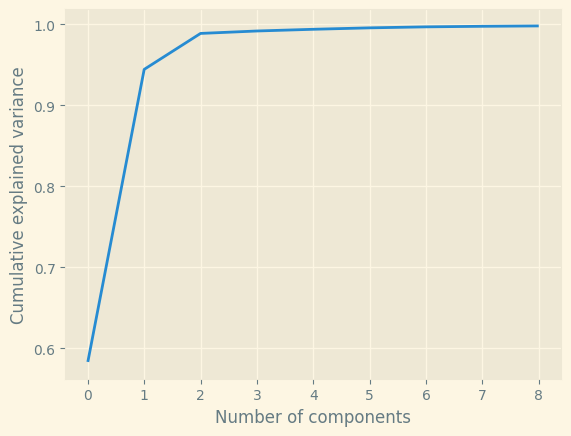

In [10]:
ev=pca.explained_variance_ratio_
print('X.shape',X.shape)
print('y.shape',y.shape)
print('EV',np.cumsum(ev))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [61]:
X, y = createImageCubes(X, y, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, 0.2)
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K)
ytrain = to_categorical(ytrain)
Xtest = Xtest.reshape(-1, windowSize, windowSize, K)
ytest = to_categorical(ytest)
Xtrain.shape, ytrain.shape

((34220, 25, 25, 9), (34220, 9))

In [10]:
def first_model(shape = (S, S, K), classes = output_units):
    X_input = Input(shape)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = ReLU()(X)
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = ReLU()(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc0')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc1')(X)
    model = Model(inputs = X_input, outputs = X, name='first_model')
    return model

In [11]:
first_model = first_model()
first_model.summary()

Model: "first_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 25, 9)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 23, 23, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 23, 23, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 9, 9, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc0 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,921 (2.10 MB)

 Trainable params: 550,729 (2.10 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
adam = Adam(learning_rate=0.001)
first_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "first_best_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = first_model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

In [50]:
filepath = "first_best_model.keras"

first_model.load_weights(filepath)
first_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

ytest.shape

c:\Users\user\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 26 variables. 



(8556, 9)

In [51]:
Y_pred_test = first_model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1326
           1       1.00      1.00      1.00      3730
           2       1.00      1.00      1.00       420
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00       269
           5       1.00      1.00      1.00      1006
           6       1.00      1.00      1.00       266
           7       1.00      1.00      1.00       737
           8       1.00      1.00      1.00       189

    accuracy                           1.00      8556
   macro avg       1.00      1.00      1.00      8556
weighted avg       1.00      1.00      1.00      8556



In [17]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
        
    return X
def convolutional_block(X, f, filters, stage, block, s = 2):
        
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
   
    return X
def ResNet50(input_shape = (S, S, L,1), classes = output_units):
    ## input layer
    input_layer = Input(input_shape)

    ## convolutional layers
    conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(input_layer)
    conv3d_shape = conv_layer1.shape
    conv_layer2 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer1)
    conv_layer3 = Conv2D(filters=64, kernel_size=(5,5), activation='relu')(conv_layer2)
    bn_conv1 = BatchNormalization(axis = 3)(conv_layer3)
    bn_conv2 = Activation('relu')(bn_conv1)
    pooling_layer1 = MaxPooling2D((3, 3), strides=(2, 2))(bn_conv2)
    Conv_block = convolutional_block(pooling_layer1, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    I_b1 = identity_block(Conv_block, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(I_b1, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2),name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    model = Model(inputs = input_layer , outputs = X, name='ResNet50')
    return model

In [18]:
model = ResNet50(input_shape = (S, S, K,1), classes = output_units)
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 25, 25, 9, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 23, 23, 7, │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 23, 23,    │          0 │ conv3d[0][0]      │
│                     │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 19, 19,    │    179,264 │ reshape[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 19, 19,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 9, 9, 64)  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 9, 9, 64)  │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 9, 9, 64)  │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 9, 9, 64)  │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ bn2a_branch2b[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 9, 9, 256) │     16,640 │ max_pooling2d[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 9, 9, 256) │     16,640 │ activation_2[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 9, 9, 256) │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 9, 9, 256) │      1,024 │ res2a_branch2c[0

 Total params: 23,776,393 (90.70 MB)

 Trainable params: 23,723,273 (90.50 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

second_filepath = "best-model_IP_Source.keras"
checkpoint = ModelCheckpoint(second_filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)


c:\Users\user\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning:

Argument `decay` is no longer supported and will be ignored.



In [62]:
# load best weights
model.load_weights("best-model_IP_Source.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [63]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

268/268 ━━━━━━━━━━━━━━━━━━━━ 44s 153ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1326
           1       1.00      1.00      1.00      3730
           2       1.00      1.00      1.00       420
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00       269
           5       1.00      1.00      1.00      1006
           6       1.00      1.00      1.00       266
           7       1.00      1.00      1.00       737
           8       1.00      1.00      1.00       189

    accuracy                           1.00      8556
   macro avg       1.00      1.00      1.00      8556
weighted avg       1.00      1.00      1.00      8556



In [66]:
classification, conf, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(conf)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('DATASET ={}'.format(dataset))
    x_file.write('\n')    
    x_file.write('Test ratio ={}'.format(test_ratio))
    x_file.write('\n')
    x_file.write('Window size ={}'.format(windowSize))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 45s 158ms/step - accuracy: 1.0000 - loss: 2.5308e-05


In [46]:
f = open("classification_report.txt", "r")
print(f.read()) 

DATASET =PU
Test ratio =0.2
Window size =25

0.002591925658634864 Test loss (%)
100.0 Test accuracy (%)

100.0 Kappa accuracy (%)
100.0 Overall accuracy (%)
100.0 Average accuracy (%)

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      1326
             Meadows       1.00      1.00      1.00      3730
              Gravel       1.00      1.00      1.00       420
               Trees       1.00      1.00      1.00       613
Painted metal sheets       1.00      1.00      1.00       269
           Bare Soil       1.00      1.00      1.00      1006
             Bitumen       1.00      1.00      1.00       266
Self-Blocking Bricks       1.00      1.00      1.00       737
             Shadows       1.00      1.00      1.00       189

            accuracy                           1.00      8556
           macro avg       1.00      1.00      1.00      8556
        weighted avg       1.00      1.00      1.00      8556

[[1326

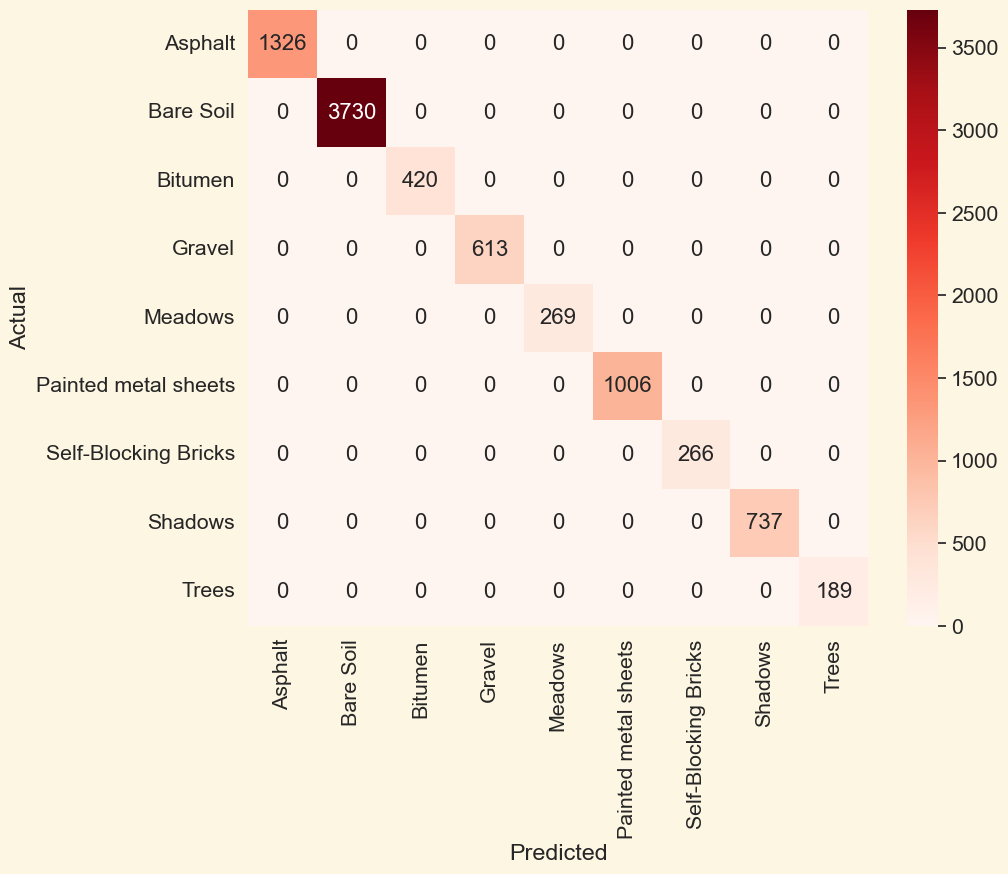

In [67]:
import pandas as pd
import seaborn as sn
if(dataset=='IP'):
    names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
elif dataset == 'SA':
    names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
elif dataset == 'PU':
    names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
elif dataset == 'PC':
    names = ['Water', 'Trees','Asphalt','Self-Blocking Bricks', 'Bitumen','Tiles', 'Shadows','Meadows','Bare Soil']  

elif(dataset=='Bot'):
    names = ['water','hippo grass','floodplain grasses1','floodplain_grasses2', 'reeds1','riparian','firescar2',
                        'island interior','acacia woodlands','acacia shrublands','acacia grasslands','short mopane','mixed mopane','exposed soils']
        

df_cm = pd.DataFrame(conf, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=1200)